# Tabla bol recognition
by Błażej Kotowski (blazej.kotowski@upf.edu) and Ninad Puranik (ninad.puranik01@estudiant.upf.edu)

### Task definition
The tabla is a pair of drums known as ‘tabla’ and ‘bayan’ commonly used in accompaniment
and solo performances in Indian Music. A variety of sounds can be produced using different
kinds of strokes on the tabla-bayan. A mnemonic syllable or bol is associated with each of
these strokes. We address the problem of recognizing the bol performed in an audio
recording of a tabla solo performance with a harmonium accompaniment. We use a
supervised learning approach to classify the ‘bols’ using the timbral features of audio and the
manual annotations from the compmusic tabla-solo dataset.

### Dataset
Tabla Solo dataset: https://compmusic.upf.edu/tabla-solo-dataset


# Implementation

In [1]:
import numpy as np
import essentia.standard as estd
import essentia as ess
import scipy
import pandas as pd
import csv
import re
import os
import IPython.display as ipd
import tempfile
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sns.set()
JUP_STDOUT = sys.stdout

# Dataset definition
In this cell we are setting dataset related parameters. These include:
- location of the dataset,
- results location,
- bols available in the dataset

They should be modified according to the local machine configuration and used dataset.

In [2]:
# Set base directory where the dataset is located
dataset_root = "./tabla_solo_1.0"

# Define the rest of paths
filelist_path = os.path.join(dataset_root, 'filelist.txt')
audio_files_path = os.path.join(dataset_root, "wav")
annotation_files_path = os.path.join(dataset_root, "onsMap")

# Filename for features to be saved and loaded from
features_filename = "extracted_features.csv"

# Path for classifier outputs 
results_path = "./results"

# List of all possible bols
BOL_NAMES = ['DA', 'KI', 'GE', 'TA', 'NA', 'DIN', 'KDA', 'TIT', 'DHA', 
        'DHE', 'DHET', 'DHI', 'DHIN', 'RE', 'TE', 'TII', 'TIN', 'TRA']

# Collect list of datafiles
filenames = [line.rstrip('\n') for line in open(filelist_path)]

# Feature extraction
### Steps
1. First we are using Essentia's Extractor class to extract all low-level features using frameSize of 1024 and hopSize of 512. Then we aggregate them using PoolAggregator and transform vectors of length N to N single-value fields.
2. Next we perform MFCCs extraction using Essentia's built-in extractor with analysis parameters of well-estabilished HTK toolkit. 
3. We calculate the MFCC derivatives of first end second order (velocity and acceleration)
4. We then merge all the features into single Pool.


In [3]:
def flatten_pool(pool):
    '''
    For each enumerable feature in a pool, create separate field for each value
    '''
    for feature in pool.descriptorNames():
        if hasattr(pool[feature], '__iter__'):
            values_list = pool[feature]
            pool.remove(feature)
            for i, elem in enumerate(values_list):
                pool.set("{}.{}".format(feature,i), elem)
    return pool


def extract_mfccs(audio_frame):
    '''
    Extracts mean mfcss from given audio frame. Mimicks behavior of HTK.
    
    Arguments:
        - audio_frame:[float] - audio frame
    Returns:
        - result:dictionary – a dictionary of calculated mean mfccs
    '''
    # HTK-like parameters for MFCC
    mfcc_extractor = estd.MFCC(
        type = 'magnitude',
        warpingFormula = 'htkMel',
        weighting = 'linear',
        highFrequencyBound = 8000,
        numberBands = 26,
        numberCoefficients = 13,
        normalize = 'unit_max',
        dctType = 3,
        logType = 'log',
        liftering = 22
    )
    
    # HTK-like Parameters for FrameGenerator
    frame_generator = estd.FrameGenerator(
        audio_frame,
        frameSize = 1102,
        hopSize = 441,
        startFromZero = True,
        validFrameThresholdRatio = 1
    )
    
    # HTK-like parameters for windowing
    window = estd.Windowing(
        type = 'hamming',
        size = 1102,
        zeroPadding = 946,
        normalized = False
    )
    
    spectrum = estd.Spectrum()
    
    features = ess.Pool()
    mfccs = []
    for frame in frame_generator:
        spec = spectrum(window(frame))
        _, mfcc_coeffs = mfcc_extractor(spec)
        mfccs.append(mfcc_coeffs)

        
    # Calculate mfccs derivatives (velocity and acceleration)
    mfccs = np.array(mfccs).T
    mfccs_delta = np.diff(mfccs)
    mfccs_delta_delta = np.diff(mfccs_delta)
    mfccs_dict = {
        'htk_mfccs': mfccs,
        'htk_mfccs_delta': mfccs_delta,
        'htk_mfccs_delta_delta': mfccs_delta_delta
    }
    for feature, mfccs in mfccs_dict.items():
        for coeff_id, values in enumerate(mfccs):
            for value in values:
                features.add("%s.%d" % (feature, coeff_id), value)

    # Pool aggregation
    aggregated = estd.PoolAggregator(defaultStats=['mean','stdev'])(features)
    return aggregated
    
    
def extract_features(audio_frame):
    '''
    Extracts multiple features using Essentia's Extractor
    
    Arguments:
        - audio_frame:[float] - audio frame
    Returns:
        - results:pool – Essentia's pool datastructure with aggregated features
    '''
    extractor = estd.Extractor(highLevel=False, 
                    midLevel=False,
                    relativeIoi=False,
                    rhythm=False,
                    tuning=False,
                    lowLevelFrameSize=1024,
                    lowLevelHopSize = 512,
                   )
    
    pool = extractor(audio_frame)
    
    pool_aggregator = estd.PoolAggregator(defaultStats=['mean','stdev'])
    return flatten_pool(pool_aggregator(pool))


def analyse_file(fname, slice_length=100, skip_length=0):
    '''
    Analyses the file at give filepath
    
    Arguments:
        - fname:path - path to the filename
        - slice_length:float - length of a bol slice in ms
        - skip_start:float - length of bol beginning to skip in ms
    Returns:
        - result:[pool] - list of Essentia's pools with extracted features for each bol
    '''
    fs = 44100
    
    # Calculate parameters
    frame_size = int(slice_length*fs/1000)
    skip_samples = int(skip_length*fs/1000)
    
    # Load audio
    audio_file = os.path.join(audio_files_path, fname+'.wav')
    audio = estd.MonoLoader(filename=audio_file)()

    # Load annotation
    annotation_file = os.path.join(annotation_files_path, fname+'.csv')
    df = pd.read_csv(annotation_file, header=None)
    
    # Extract features
    bols = []
    bols_number = {}
    for item in df.itertuples(index=False):
        timestamp = item[0]
        
        # 'Class'
        bol_name = item[1].strip()
        bol_id = BOL_NAMES.index(bol_name)
        if bol_id not in bols_number:
            bols_number[bol_id] = 0
        bols_number[bol_id] += 1

        start_frame = int(np.round(timestamp*fs)) + skip_samples
        end_frame = start_frame + frame_size
        audio_slice = audio[start_frame : end_frame]
        
        extractor_pool = extract_features(audio_slice)
        mfcc_pool = extract_mfccs(audio_slice)
        extractor_pool.merge(mfcc_pool)
        extractor_pool.set('bol_id', bol_id)
        
        bols.append(extractor_pool)
        
    return bols
        

## Perform extraction
We are separating bols from audio using annotation data. We cut arbitrary selected 100ms of audio, starting from the annotated onset of a given bol. Such audio slice we treat as a representation of annotated bol from which we extract features. 

In [7]:
# Extract all features
slice_length = 100 # ms
skip_length = 0 # ms
pools = []
for fname in filenames:
    pools += analyse_file(fname, slice_length, skip_length)

## Export features to a file
We are saving features to CSV file in order to avoid the necessity of repeating time-consuming and computationally expensive operation of extracting the features. There are some frames that caused problems during analysis, however the number was neglectable in the scope of our task. Essentia doesn't provide any method of generating CSV from pool, so we had to implement the method ourselves.

In [15]:
# Save features to CSV file
attributes = pools[0].descriptorNames()
problematic_frames = 0
with open(features_filename, "w") as file:
    file.write(",".join(attributes) + "\n")
    attributes.remove('bol_id')
    for pool in pools:
        try:
            bol_name = BOL_NAMES[int(pool['bol_id'])]
            vals = [bol_name]
            vals += ([pool[attribute] for attribute in attributes])
            file.write(",".join([str(item) for item in vals])+"\n")
        except KeyError:
            problematic_frames += 1
            
print("Saved features to %s. There was a problem with %d out of %d frames." % (features_filename, problematic_frames, len(pools)))

Saved features to extracted_features.csv. There was a problem with 6 out of 8245 frames.


## Load features
We are loading the extracted features from the file. We decided to use Pandas for further analysis.

In [5]:
# Convert 'NA' syllable back to 'NA' (Pandas converts NA values to NaN)
df = pd.read_csv(features_filename, converters={'bol_id': lambda x: BOL_NAMES.index(str(x))})

## Generate representation plot
We are plotting the number of samples for each bol in the given dataset.

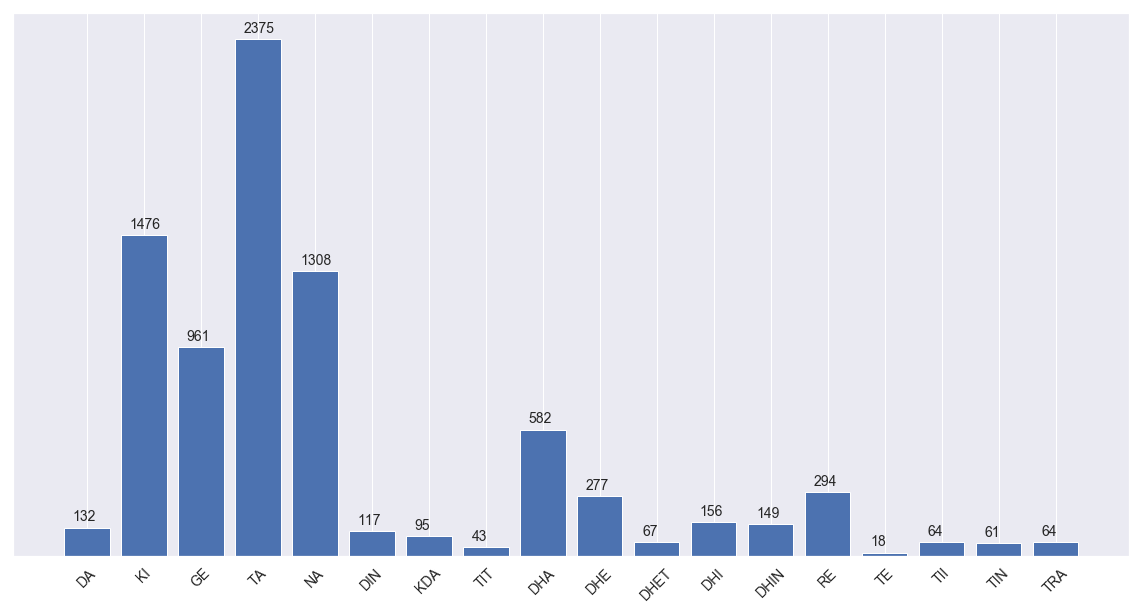

In [56]:
# For statistical purposes
bols_number = {}
for name in range(len(BOL_NAMES)):
    bols_number[name] = len(df[df['bol_id'] == name])
    
x_bols = np.arange(len(bols_number))
y_bols = bols_number.values()

fig = plt.figure(figsize=(20,10))

barplot = plt.bar(x_bols, y_bols)
plt.xticks(x_bols, BOL_NAMES, rotation=45, fontsize=14)
plt.yticks([])
for i, v in enumerate(y_bols):
    plt.text(i-.25, v+30, str(v), fontsize=14)
plt.show()

fig.savefig(os.path.join(results_path, "dataset_representation.pdf"))

# Classification
We are providing a training and evaluation framework based of scikit-learn. We are then testing performance of different feature sets in combination with different classifiers.
### Feature sets we are considering include:
- All the features available,
- Only MFCCs extracted by Essentia's Extractor class,
- Only MFCCs extracted with custom, HTK-based extraction method, together with their derivatives,
- All the features excluding MFCC extracted by Essentia's Extractor class.

### Classifiers we are testing include:
- K-Nearest Neighbour
- Support Vector Machine with PolyKernel and gamma scaling
- Decision Tree

### Training / Testing split
1. We are keeping 10% of our data just for testing.
2. With the remaining 90% we traing our classifier and perform 10-fold cross validation.
3. With a trained classifier perform final classification test and report using following metrics:
    - confusion matrix
    - precision
    - recall
    - f1-score
    - support
    - averages and weighted averages of all mentioned metrics

## Training classifiers

In [7]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=11):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 11.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='center', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [59]:
def report(clf, X, y, clf_name, log_to_file=False):
    if log_to_file:
        # Create results directory if doesn't exist
        try:  
            os.mkdir(results_path)
        except:
            # Directory already exists
            pass
        # Redirect stdout
        textfile = open(os.path.join(results_path, clf_name+'.txt'), 'w')
        sys.stdout = textfile
    
    print("Results for %s classifier\n\n" % clf_name)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random.randint(0,10000))
    k_fold = KFold(10)
    print("----------------------------------------------------")
    print("10-fold validation results\n")
    for k, (train, test) in enumerate(k_fold.split(X_train, y_train)):
        clf.fit(X_train[train], y_train[train])
        acc = clf.score(X_train[test], y_train[test])
        print("Fold no %d: %f accuracy." % (k+1, acc))
        
    y_predict = clf.predict(X_test)
    unique_classes = np.unique(list(y_test) +  list(y_predict))
    class_names = [BOL_NAMES[class_id] for class_id in sorted(unique_classes)]
    clf_report = classification_report(y_test, y_predict, target_names=class_names)
    
    print("----------------------------------------------------")
    print("\nClassification report\n")
    print(clf_report)
    
    # Calculate and save confusion matrix figure
    cm = confusion_matrix(y_test, y_predict)
    print("----------------------------------------------------")
    print(cm)
    cmfig = print_confusion_matrix(cm, class_names)

    if log_to_file:
        cmfig.savefig(os.path.join(results_path, clf_name+'--cm.pdf'))
        textfile.close()
    sys.stdout = JUP_STDOUT

In [60]:
# FEATURE SELECTION: Uncomment expected behavior

all_columns = list(df.columns)
all_columns.remove('bol_id')

# All the columns
# fset_id = 'all'
# selected_columns = all_columns

# Only automatically computed mfccs
fset_id = 'lowLevel.mfcc'
selected_columns = [column for column in all_columns if 'lowLevel.mfcc' in column]

# Only htk MFCCs + derivatives
# fset_id = 'htk_mfcc'
# selected_columns = [column for column in all_columns if 'htk_mfcc' in column]

# All features apart of automatically computed mfccs
# fset_id = 'not-lowLevel.mfcc'
# selected_columns = [column for column in all_columns if 'lowLevel.mfcc' not in column]

# Get features matrix
X = df[selected_columns].values
# Extract classes
y = df['bol_id'].values

In [3]:
# K-Nearest Neighbour
knn_clf = KNeighborsClassifier()
report(knn_clf, X, y, 'knn'+fset_id, log_to_file=True)

In [4]:
# Support Vector Machine
svm_clf = svm.SVC(kernel='poly', C=1, degree=3, gamma='scale')
report(svm_clf, X, y, 'svn--'+fset_id, log_to_file=True)

In [5]:
# Descision tree
tree = DecisionTreeClassifier()
report(tree, X, y, 'tree--'+fset_id, log_to_file=True)

# Conclusions
- SVM is the best performing classifier for defined task.
- Speech-oriented HTK parameters for MFCC extraction perform suprisingly well for tabla classification problem.
- Adding temporal features (MFCC derivatives) may be very important for correct timbral classification.
- Spectral features are those that matter the most in case of tabla bol recognition.

# Future work
### Feature extraction
- Harmonium could be separated from the audio using Harmonic / Residual model. This could possibly raise the quality of extracted features.

### Classification
- Feature selection techniques could be further explored.

### Transcription
- We could use onset detection coupled with this trained model to do an end-to end tabla transcription.

# References
- S. Gupta, A. Srinivasamurthy, M. Kumar, H. A. Murthy, X. Serra. Discovery of Syllabic Percussion Patterns in Tabla Solo Recordings. In Proc. of the 16th International Society for Music Information Retrieval Conference (ISMIR), 2015. http://compmusic.upf.edu/ismir-2015-tabla
- P. Chordia. Segmentation and recognition of tabla strokes. In Proc. of the 6th International Conference on Music Information Retrieval (ISMIR), pages 107–114, London, UK, September 2005. ​http://ismir2005.ismir.net/proceedings/1137.pdf